# Compte Rendu Projet - Fabien Behra

Voici le compte rendu du projet du module Documents Multimédia & Recherche.
Il contient le détail des travaux réalisés tout le long de ce projet, les étapes de réflexions, les résultats, les echecs...
Tous les travaux ont été réalisés par Fabien Behra.

- [x]  Fonction spécifique pour le calcul de l'erreur (ou de la précision) globale sur l'ensemble de test
- [x]  Appel de cette fonction avant la première itération (époque) et après chaque itération
- [x]  Affichage de l'évolution de l'erreur (ou de la précision) globale en fonction des itérations
- [x]  Essais de modification de l'architecture du réseau (taille, nombre et/ou types des couches) ou de conditions d'apprentissage (augmentation de données)
- [x]  Description complète de votre réseau final avec : nombre de couches et sous-couches, identification de toutes les variables intermédiaires (les “Xn”) de l'entrée à la sortie et en donnant leurs dimensions (tailles de tenseurs) ; identification de toutes les fonctions successives (les “Fn”) avec leurs types ; et identification de tous les paramètres de ces fonctions (les “Wn”), en donnant leurs dimensions (tailles de tenseurs) et en précisant éventuellement s'ils sont nuls (pas de paramètres pour la fonction correspondante).
- [X]  Calcul du nombre d'opérations flottantes effectuées pour les passes avant (le nombre d'opérations pour les passes arrières, quand il y en a, est quasiment le même) pour une image ; on comptera une opération pour une addition, pour une multiplication ou pour un maximum, même si ces opérations sont de complexités différentes.
- [X]  Calcul du nombre total d'opérations pour une époque, incluant les passes avant et arrière pour les images d'entraînement et uniquement une passe avant pour les images de test.
- [X]  Même calcul pour l'entraînemenent et l'évaluation en continu sur l'ensemble des époques.
- [x]  Calcul en nombre total d'opérations flottantes par seconde sur la durée d'entraînement.
- [x]  Et, finalement, la meilleure performance obtenue avec les contraintes de nombre de paramètres et de temps d'entraînement.

## 1. Jeu d'entrainement

### Définition du jeu d'entrainement
Pour le jeu de test, on importe 10,000 images de 32px par 32px. 

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms

#Augmentation de données
# Modification des images en entrée, (Crop, flip) pour augmenter la précision du réseau
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#peut être augmenté pour être plus rapide -> Mettre + d'epochs
batch_size = 16

# jeu d'entrainement
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Charge les images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# jeu de vérification
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes à identifier
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Verification de la bonne relation image - classe du jeu d'entrainement
On vérifie sur 16 images la bonne correspondance de la classe.

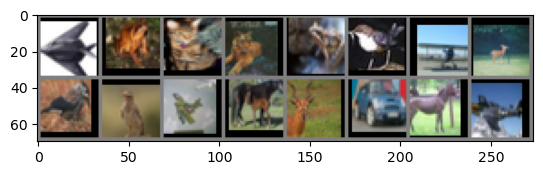

plane frog  cat   cat   frog  bird  plane deer  bird  bird  plane horse deer  car   horse plane


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Définition des méthodes d'évaluation

In [31]:
# Méthode qui détermine la précision globale du réseau
def getNetworkAccuracy(net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

In [32]:
# Méthode qui détermine la précision du réseau pour chaque classe possible
def getClassAccuracy(net):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    net.eval()

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            #images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## 3. Définition de la méthode d'entrainement

In [33]:
# Définition de la méthode d'entrainement
import time

def trainNetwork(net):

    # démarre le timer général
    trainingStartTime = time.time()
    
    # Affiche la précision du réseau sans entrainement
    print('------ EPOCH 0 ---(Avg loss: NA)---------')
    getNetworkAccuracy(net)
    getClassAccuracy(net)

    # 110 epochs pour rester en dessous de l'heure d'entrainement
    rangeEpochs = range(110)
    for epoch in rangeEpochs:  # loop over the dataset multiple times
        # Démarre le timer pour une epoch
        basetime = time.time()
        running_loss = 0.0

        #On met le réseau en mode entrainement puisqu'on utilise des dropout et des batchNormalization
        net.train()
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        #On met le réseau en mode evaluation avant d'évaluer le réseau
        net.eval()
        print(f'------ EPOCH {epoch+1} : ({(time.time() - basetime):.2f}s)---(Avg loss:{running_loss/i:.3f})--------')
        getNetworkAccuracy(net)
        
        # pour la dernière epoch, on affiche la précision de chaque classe
        if epoch == rangeEpochs[-1]:
            getClassAccuracy(net)

    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    print(f'Finished Training : ({(time.time() - trainingStartTime):.2f}s)')

## 4. Définition du CNN initial

Voici le réseau initial, duquel je suis parti pour concevoir mon réseau final
```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Il possède 62,000 paramètres

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
================================================================
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
```

Pour une précision de 60% avec un AVG loss de 1.108 en 4 epoch

```
-------------EPOCH 0-------------
Accuracy of the network on the 10000 test images: 9 %
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 99.6 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %

-------------EPOCH 1: time:(39.317s), AVG loss:(1.709)-------------
Accuracy of the network on the 10000 test images: 50 %

-------------EPOCH 2: time:(39.577s), AVG loss:(1.333)-------------
Accuracy of the network on the 10000 test images: 55 %

-------------EPOCH 3: time:(39.354s), AVG loss:(1.199)-------------
Accuracy of the network on the 10000 test images: 57 %

-------------EPOCH 4: time:(39.478s), AVG loss:(1.108)-------------
Accuracy of the network on the 10000 test images: 60 %
Accuracy for class: plane is 56.2 %
Accuracy for class: car   is 83.9 %
Accuracy for class: bird  is 33.3 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 54.3 %
Accuracy for class: dog   is 48.8 %
Accuracy for class: frog  is 67.5 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 73.6 %
Accuracy for class: truck is 64.9 %
```


## 5. Tests & améliorations effectués
Pour le bien de ce compte-rendu, je n'ai mis que les tests "majeurs" où des conclusions ont pu être tirées. En réalité, j'ai noté le résultat de 29 tests.

### Test 1 : Découverte
Pour les premiers tests, je me suis contenté de modifier des chiffres aléatoirement mais avec une certaine logique tout de même. Pour ce test, voici les modifications:
- Passage d'une convolution de (3, 6, 5) -> (3, 18, 5) au départ
- Faire correspondre les bons chiffres pour la suite

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 18, 5) # -> anciennement (3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 54, 5) # -> anciennement (6, 16, 5)
        self.fc1 = nn.Linear(54 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Paramètres & résultats
```
NB TOTAL PARAMETERS : 198856
torch.Size([18, 3, 5, 5])
torch.Size([18])
torch.Size([54, 18, 5, 5])
torch.Size([54])
torch.Size([120, 1350])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
-------SUMMARY-------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 18, 28, 28]           1,368
         MaxPool2d-2           [-1, 18, 14, 14]               0
            Conv2d-3           [-1, 54, 10, 10]          24,354
         MaxPool2d-4             [-1, 54, 5, 5]               0
            Linear-5                  [-1, 120]         162,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
================================================================
Total params: 198,856
Trainable params: 198,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.76
Estimated Total Size (MB): 0.96
----------------------------------------------------------------

RESULTS : Accuracy 56% 
Final loss: 1.277
```

### Test 2 : Ajout de convolutions
Avec le premier test peu concluant, mais avec 50k paramètres de marge, je décide donc de :
- changer les convolutions
- ajouter une convolution
- changer les fonctions linéaires
Sans trop d'objectifs, uniquement dans un but d'observation.

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 3) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 3) #entrée 30 -> 28
        self.conv3 = nn.Conv2d(32, 120, 3) #entrée 14 -> 12
        self.fc1 = nn.Linear(120 * 6 * 6, 50) #completement connectée
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 10)

   def forward(self, x):

        x = F.relu(self.conv1(x)) # -> 15 taille de couche
        x = self.pool(F.relu(self.conv2(x))) # -> entrée 28 tailles -> 14 tailles 
        x = self.pool(F.relu(self.conv3(x))) # -> 14 -> 12 -> 6
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Paramètres & Résultats
```
NB TOTAL PARAMETERS : 256394

------ EPOCH 1 : (34.20s)---(Avg loss:1.664)--------
Accuracy of the network on the 10000 test images: 52 %

------ EPOCH 2 : (31.80s)---(Avg loss:1.130)--------
Accuracy of the network on the 10000 test images: 64 %

------ EPOCH 3 : (34.59s)---(Avg loss:0.899)--------
Accuracy of the network on the 10000 test images: 68 %

------ EPOCH 4 : (36.36s)---(Avg loss:0.754)--------
Accuracy of the network on the 10000 test images: 70 %
```

Résultat probant, mais limité en nombre de paramètres, il faut trouver autre chose.

### Test 3 : Ajout de normalisations
```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##Normalise la martice convolution -> Parameter nb couche conv
        self.batchNorm1 = nn.BatchNorm2d(12)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.batchNorm3 = nn.BatchNorm2d(120)
        
        self.conv1 = nn.Conv2d(3, 12, 3) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 3) #entrée 30 -> 28
        self.conv3 = nn.Conv2d(32, 120, 3) #entrée 14 -> 12
        self.fc1 = nn.Linear(120 * 6 * 6, 10) #completement connectée

def forward(self, x):

        x = F.relu(self.batchNorm1(self.conv1(x))) # -> 28 taille de couche
        x = F.relu(self.batchNorm2(self.conv2(x)))  
        x = self.pool(x) # -> 14 taille de couche
        x = self.pool(F.relu(self.batchNorm3(self.conv3(x)))) # -> 4
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x
```

Paramètres & Résultats
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Conv2d: 1-1                            [-1, 12, 30, 30]          336
├─BatchNorm2d: 1-2                       [-1, 12, 30, 30]          24
├─Conv2d: 1-3                            [-1, 32, 28, 28]          3,488
├─BatchNorm2d: 1-4                       [-1, 32, 28, 28]          64
├─MaxPool2d: 1-5                         [-1, 32, 14, 14]          --
├─Conv2d: 1-6                            [-1, 120, 12, 12]         34,680
├─BatchNorm2d: 1-7                       [-1, 120, 12, 12]         240
├─MaxPool2d: 1-8                         [-1, 120, 6, 6]           --
├─Linear: 1-9                            [-1, 10]                  43,210
==========================================================================================
Total params: 82,042
Trainable params: 82,042
Non-trainable params: 0
Total mult-adds (M): 8.02
==========================================================================================
Input size (MB): 0.01
Forward/backward pass size (MB): 0.81
Params size (MB): 0.31
Estimated Total Size (MB): 1.14
==========================================================================================

------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 68 %

 ------ EPOCH 1 : (49.26s)---(Avg loss:0.781)--------
Accuracy of the network on the 10000 test images: 69 %Accuracy for class: truck is 80.8 %

 ------ EPOCH 2 : (48.54s)---(Avg loss:0.709)--------
Accuracy of the network on the 10000 test images: 70 %

 ------ EPOCH 3 : (49.17s)---(Avg loss:0.656)--------
Accuracy of the network on the 10000 test images: 71 %
```

J'ai ajouté les normalisation suite au conseil du prof, cela permet de normaliser le résultat et de forcer le réseau à s'améliorer, ce qui améliore la précision générale du réseau. Il faut une normalisation par convolution afin de pouvoir mettre plus de convolutions.

### Test 4 : Ajout du dropout, et idée globale de la structure du réseau
A partir de ce test, l'idée de la structure du réseau est posée. Il s'agit de jouer avec un maximum de convolution, avec un gap réfléchi (ici, x2) et un padding de 1, ne réduisant pas la taille de couche, et permettant donc d'augmenter le nombre de convolutions.

Une particularité de ce réseau, c'est d'avoir des convolutions ne changeant pas le nombre de couches, hypothèse qui pourrait améliorer la précision.

L'ajout du dropout() nous a été conseillé par le prof. L'idée est d'effacer une partie du résultat (en remplacant des 1 par des 0) pour forcer le réseau à s'adapter aux erreurs. Ici, et pour le réseau final, le dropout est de 0.2. C'est la valeur idéal sachant que l'augmenter légèrement n'a pas d'impact positif sur le réseau.

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 3 normalisations
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.batchNorm3 = nn.BatchNorm2d(64)
        
        #Dropout pour remplacer des 1 par des 0
        self.dropout = nn.Dropout(0.2)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)
        
        # 5 Convolutions, dont 2 qui ne changent pas le nombre de couche.
        # Padding de 1 pour ne pas réduire la taille de couche de sortie, et enchainer plus de convolutions.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1) # Test pouvant permettre l'amélioration de la précision du réseau
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) 
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1) 
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1) 
        
        #Fcts
        self.fc1 = nn.Linear(64 * 4 * 4, 10) #completement connectée

    # Le réseau fonctionne par "paquet", chaque paquet possède deux convolutions + Norm + relu, 
    # avec un pool de ces 2 convolutions.
    # On répète ce paquet 3x fois ou presque
    # On linéarise et dropout le résultat général
    def forward(self, x):
        x = F.relu(self.batchNorm1(self.conv1(x))) #32
        x = F.relu(self.batchNorm1(self.conv2(x))) #32
        x = self.pool(x) # -> 16
        x = F.relu(self.batchNorm2(self.conv3(x))) #16
        x = F.relu(self.batchNorm2(self.conv4(x))) #16
        x = self.pool(x) # -> 8
        x = F.relu(self.batchNorm3(self.conv5(x))) #8
        x = self.pool(x) # -> 4
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x
```

Paramètres & Résultats
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
      BatchNorm2d-12             [-1, 64, 8, 8]             128
        MaxPool2d-13             [-1, 64, 4, 4]               0
          Dropout-14                 [-1, 1024]               0
           Linear-15                   [-1, 10]          10,250
================================================================
Total params: 45,722
Trainable params: 45,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 0.17
Estimated Total Size (MB): 1.06
----------------------------------------------------------------

Résultat sur 20 epochs pour maximiser la précision

------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 10.2 %

------ EPOCH 1 : (16.85s)---(Avg loss:1.352)--------
Accuracy of the network on the 10000 test images: 61.78 %

 ------ EPOCH 2 : (16.72s)---(Avg loss:0.972)--------
Accuracy of the network on the 10000 test images: 66.67 %

 ------ EPOCH 3 : (17.15s)---(Avg loss:0.840)--------
Accuracy of the network on the 10000 test images: 69.91 %

...

 ------ EPOCH 18 : (17.38s)---(Avg loss:0.437)--------
Accuracy of the network on the 10000 test images: 76.83 %

 ------ EPOCH 19 : (16.55s)---(Avg loss:0.426)--------
Accuracy of the network on the 10000 test images: 76.25 %

 ------ EPOCH 20 : (16.94s)---(Avg loss:0.412)--------
Accuracy of the network on the 10000 test images: 77.19 %
```

### Test 5 : Ajout de convolutions, normalisation et structure quasi finale

Ce réseau défini l'idée qu'a le réseau de fin, avec des valeurs différentes. L'idée est d'avoir le plus de convolutions en respectant le nombre de paramètres max. Autant de normalisation, et un nombre de couche finale pas si élevé (90 ici).

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##Normalise la martice convolution -> Parameter nb couche conv
        self.batchNorm1 = nn.BatchNorm2d(15)
        self.batchNorm2 = nn.BatchNorm2d(30)
        self.batchNorm3 = nn.BatchNorm2d(45)
        self.batchNorm4 = nn.BatchNorm2d(55)
        self.batchNorm5 = nn.BatchNorm2d(62)
        self.batchNorm6 = nn.BatchNorm2d(70)
        self.batchNorm7 = nn.BatchNorm2d(85)
        self.batchNorm8 = nn.BatchNorm2d(90)
        
        #Dropout
        self.dropout = nn.Dropout(0.2)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)

        # Augmentation du nombre de couche de 15 à chaque convolutions sauf 5 pour la dernière pour rester en dessous du nombre de params max.        
        self.conv1 = nn.Conv2d(3, 15, 3, padding=1) 
        self.conv2 = nn.Conv2d(15, 30, 3, padding=1) 
        self.conv3 = nn.Conv2d(30, 45, 3, padding=1) 
        self.conv4 = nn.Conv2d(45, 55, 3, padding=1) 
        self.conv5 = nn.Conv2d(55, 62, 3, padding=1) 
        self.conv6 = nn.Conv2d(62, 70, 3, padding=1) 
        self.conv7 = nn.Conv2d(70, 85, 3, padding=1)
        self.conv8 = nn.Conv2d(85, 90, 3, padding=1)
        
        #Fcts
        self.fc1 = nn.Linear(90 * 4 * 4, 10) #completement connectée
    
    def forward(self, x):
        x = F.relu(self.batchNorm1(self.conv1(x))) #32
        x = F.relu(self.batchNorm2(self.conv2(x))) #32
        x = self.pool(x) # -> 16
        
        x = F.relu(self.batchNorm3(self.conv3(x))) #16
        x = F.relu(self.batchNorm4(self.conv4(x))) #16
        x = self.pool(x) # -> 8
        
        x = F.relu(self.batchNorm5(self.conv5(x))) #8
        x = F.relu(self.batchNorm6(self.conv6(x))) #8
        x = self.pool(x) # -> 4
        
        x = F.relu(self.batchNorm7(self.conv7(x))) #4
        x = F.relu(self.batchNorm8(self.conv8(x))) #4
        # Pas de pool pour garder une taille finale pas trop petite

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x
```

Paramètres
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 15, 32, 32]             420
       BatchNorm2d-2           [-1, 15, 32, 32]              30
            Conv2d-3           [-1, 30, 32, 32]           4,080
       BatchNorm2d-4           [-1, 30, 32, 32]              60
         MaxPool2d-5           [-1, 30, 16, 16]               0
            Conv2d-6           [-1, 45, 16, 16]          12,195
       BatchNorm2d-7           [-1, 45, 16, 16]              90
            Conv2d-8           [-1, 55, 16, 16]          22,330
       BatchNorm2d-9           [-1, 55, 16, 16]             110
        MaxPool2d-10             [-1, 55, 8, 8]               0
           Conv2d-11             [-1, 62, 8, 8]          30,752
      BatchNorm2d-12             [-1, 62, 8, 8]             124
           Conv2d-13             [-1, 70, 8, 8]          39,130
      BatchNorm2d-14             [-1, 70, 8, 8]             140
        MaxPool2d-15             [-1, 70, 4, 4]               0
           Conv2d-16             [-1, 85, 4, 4]          53,635
      BatchNorm2d-17             [-1, 85, 4, 4]             170
           Conv2d-18             [-1, 90, 4, 4]          68,940
      BatchNorm2d-19             [-1, 90, 4, 4]             180
          Dropout-20                 [-1, 1440]               0
           Linear-21                   [-1, 10]          14,410
================================================================
Total params: 246,796
Trainable params: 246,796
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.37
Params size (MB): 0.94
Estimated Total Size (MB): 2.32
----------------------------------------------------------------
```

Résultats sur 20 époques
```
------ EPOCH 1 : (18.50s)---(Avg loss:1.257)--------
Accuracy of the network on the 10000 test images: 65.13 %

 ------ EPOCH 2 : (16.95s)---(Avg loss:0.836)--------
Accuracy of the network on the 10000 test images: 73.18 %

 ------ EPOCH 3 : (16.51s)---(Avg loss:0.679)--------
Accuracy of the network on the 10000 test images: 74.53 %

...

 ------ EPOCH 18 : (16.43s)---(Avg loss:0.092)--------
Accuracy of the network on the 10000 test images: 80.23 %

 ------ EPOCH 19 : (16.60s)---(Avg loss:0.083)--------
Accuracy of the network on the 10000 test images: 79.98 %

 ------ EPOCH 20 : (16.46s)---(Avg loss:0.077)--------
Accuracy of the network on the 10000 test images: 79.4 %
Accuracy for class: plane is 80.2 %
Accuracy for class: car   is 92.3 %
Accuracy for class: bird  is 74.1 %
Accuracy for class: cat   is 66.0 %
Accuracy for class: deer  is 78.1 %
Accuracy for class: dog   is 75.4 %
Accuracy for class: frog  is 87.2 %
Accuracy for class: horse is 83.0 %
Accuracy for class: ship  is 81.7 %
Accuracy for class: truck is 90.3 %
Finished Training : (371.82s)
```

### Test 6 : Structure finale + test sur dropout
Avec les différents test non rapporté de ce compte rendu, j'ai remarque que le gap idéal pour les convolutions est entre 10 & 15. Ce gap permet d'avoir un bon nombre de convolutions sans augmenter drastiquement le nombre de paramètres.

Sur ce réseau, le gap est de 10. C'est une observation commune avec les autres groupes, 10 de gap permet d'avoir 9 convolutions et donc d'améliorer la précision du réseau.

Ce réseau teste aussi un dropout à 0.4 pour voir si le réseau s'améliore.
```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 9 Normalisations
        self.batchNorm1 = nn.BatchNorm2d(13)
        self.batchNorm2 = nn.BatchNorm2d(23)
        self.batchNorm3 = nn.BatchNorm2d(33)
        self.batchNorm4 = nn.BatchNorm2d(43)
        self.batchNorm5 = nn.BatchNorm2d(53)
        self.batchNorm6 = nn.BatchNorm2d(63)
        self.batchNorm7 = nn.BatchNorm2d(73)
        self.batchNorm8 = nn.BatchNorm2d(83)
        self.batchNorm9 = nn.BatchNorm2d(93)
        
        #Dropout de 0.4 pour tester
        self.dropout = nn.Dropout(0.4)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)
        
        # 9 convolutions de 10 de gap
        self.conv1 = nn.Conv2d(3, 13, 3, padding=1) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.conv2 = nn.Conv2d(13, 23, 3, padding=1) 
        self.conv3 = nn.Conv2d(23, 33, 3, padding=1) 
        self.conv4 = nn.Conv2d(33, 43, 3, padding=1) 
        self.conv5 = nn.Conv2d(43, 53, 3, padding=1) 
        self.conv6 = nn.Conv2d(53, 63, 3, padding=1) 
        self.conv7 = nn.Conv2d(63, 73, 3, padding=1)
        self.conv8 = nn.Conv2d(73, 83, 3, padding=1)
        self.conv9 = nn.Conv2d(83, 93, 3, padding=1)
        
        #Fcts
        self.fc1 = nn.Linear(93 * 4 * 4, 10) #completement connectée
    
    def forward(self, x):

        # Structure finale
        x = F.relu(self.batchNorm1(self.conv1(x))) #32
        x = F.relu(self.batchNorm2(self.conv2(x))) #32
        x = F.relu(self.batchNorm3(self.conv3(x))) #32
        x = self.pool(x) # -> 16
        
        x = F.relu(self.batchNorm4(self.conv4(x))) #16
        x = F.relu(self.batchNorm5(self.conv5(x))) #16
        x = F.relu(self.batchNorm6(self.conv6(x))) #16
        x = self.pool(x) # -> 8
        
        x = F.relu(self.batchNorm7(self.conv7(x))) #8
        x = F.relu(self.batchNorm8(self.conv8(x))) #8
        x = F.relu(self.batchNorm9(self.conv9(x))) #8
        x = self.pool(x) # -> 4
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x
```

Paramètres
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 13, 32, 32]             364
       BatchNorm2d-2           [-1, 13, 32, 32]              26
            Conv2d-3           [-1, 23, 32, 32]           2,714
       BatchNorm2d-4           [-1, 23, 32, 32]              46
            Conv2d-5           [-1, 33, 32, 32]           6,864
       BatchNorm2d-6           [-1, 33, 32, 32]              66
         MaxPool2d-7           [-1, 33, 16, 16]               0
            Conv2d-8           [-1, 43, 16, 16]          12,814
       BatchNorm2d-9           [-1, 43, 16, 16]              86
           Conv2d-10           [-1, 53, 16, 16]          20,564
      BatchNorm2d-11           [-1, 53, 16, 16]             106
           Conv2d-12           [-1, 63, 16, 16]          30,114
      BatchNorm2d-13           [-1, 63, 16, 16]             126
        MaxPool2d-14             [-1, 63, 8, 8]               0
           Conv2d-15             [-1, 73, 8, 8]          41,464
      BatchNorm2d-16             [-1, 73, 8, 8]             146
           Conv2d-17             [-1, 83, 8, 8]          54,614
      BatchNorm2d-18             [-1, 83, 8, 8]             166
           Conv2d-19             [-1, 93, 8, 8]          69,564
      BatchNorm2d-20             [-1, 93, 8, 8]             186
        MaxPool2d-21             [-1, 93, 4, 4]               0
          Dropout-22                 [-1, 1488]               0
           Linear-23                   [-1, 10]          14,890
================================================================
Total params: 254,920
Trainable params: 254,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.06
Params size (MB): 0.97
Estimated Total Size (MB): 3.04
----------------------------------------------------------------
```

Résultats sur 40 époques
```
------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 11.11 %
Accuracy for class: plane is 27.7 %
Accuracy for class: car   is 13.1 %
Accuracy for class: bird  is 0.5 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 51.7 %
Accuracy for class: dog   is 13.6 %
Accuracy for class: frog  is 1.8 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 3.1 %
Accuracy for class: truck is 2.6 %
Avg loss: NA

 ------ EPOCH 1 : (28.85s)---(Avg loss:1.404)--------
Accuracy of the network on the 10000 test images: 61.89 %

 ------ EPOCH 2 : (26.58s)---(Avg loss:0.925)--------
Accuracy of the network on the 10000 test images: 70.76 %

 ------ EPOCH 3 : (27.26s)---(Avg loss:0.753)--------
Accuracy of the network on the 10000 test images: 73.43 %

...

 ------ EPOCH 37 : (26.69s)---(Avg loss:0.057)--------
Accuracy of the network on the 10000 test images: 82.45 %

 ------ EPOCH 38 : (26.60s)---(Avg loss:0.048)--------
Accuracy of the network on the 10000 test images: 82.58 %

 ------ EPOCH 39 : (27.40s)---(Avg loss:0.048)--------
Accuracy of the network on the 10000 test images: 82.23 %

 ------ EPOCH 40 : (29.24s)---(Avg loss:0.050)--------
Accuracy of the network on the 10000 test images: 82.36 %
Accuracy for class: plane is 84.6 %
Accuracy for class: car   is 92.9 %
Accuracy for class: bird  is 74.4 %
Accuracy for class: cat   is 72.9 %
Accuracy for class: deer  is 79.7 %
Accuracy for class: dog   is 78.4 %
Accuracy for class: frog  is 88.2 %
Accuracy for class: horse is 88.7 %
Accuracy for class: ship  is 91.7 %
Accuracy for class: truck is 89.0 %
Finished Training : (1165.68s)
```

### Conclusion
Après ce dernier test, les améliorations du réseau ont été faites suite à l'augmentation de donnée, ainsi qu'un plus grand nombre d'époques.

## 6. Définition du CNN final

Au cours des mes recherches, j'ai conclu plusieurs choses :
- Utiliser des convolution avec un padding de 1 ne réduit pas la taille de couche de sortie, ce qui permet d'en faire plus.
- Augmenter drastiquement le nombre de couche augmente tout aussi drastiquement le nombre de paramètres.
- Les fonctions linéaires on un impact énorme sur le nombre de paramètres.

La logique du réseau est simple: 
- commencer avec 3 couches et augmenter ce nombre de 10 à chaque convolution jusqu'à atteindre le nombre max de paramètres.
- Pour chaque convolution, on applique dessus une normalisation, auquel on applique un relu.
- On fait 3x ces opérations, puis on divise la taille de couche avec un pooling.
- On répète ce pattern 3x 
- On applique un flatten
- On applique un dropout de 0.2 pour détruire 20% des données
- Enfin on applique un linéaire qui va réduire à 10 couches

In [34]:
# Définition du réseau CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Normalise la martice convolution -> Parameter nb couche conv
        #9 Normalisations, 1 pour chaque convolution avec les bons paramètres
        self.batchNorm1 = nn.BatchNorm2d(13)
        self.batchNorm2 = nn.BatchNorm2d(23)
        self.batchNorm3 = nn.BatchNorm2d(33)
        self.batchNorm4 = nn.BatchNorm2d(43)
        self.batchNorm5 = nn.BatchNorm2d(53)
        self.batchNorm6 = nn.BatchNorm2d(63)
        self.batchNorm7 = nn.BatchNorm2d(73)
        self.batchNorm8 = nn.BatchNorm2d(83)
        self.batchNorm9 = nn.BatchNorm2d(93)
        
        #Dropout
        self.dropout = nn.Dropout(0.2)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)
        
        #Augmenter rapidement le nombre de output au début
        ##padding =1 -> Sans rognage on reste à 32 tailles de couches
        self.conv1 = nn.Conv2d( 3, 13, 3, padding=1) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.conv2 = nn.Conv2d(13, 23, 3, padding=1) 
        self.conv3 = nn.Conv2d(23, 33, 3, padding=1) 
        self.conv4 = nn.Conv2d(33, 43, 3, padding=1) 
        self.conv5 = nn.Conv2d(43, 53, 3, padding=1) 
        self.conv6 = nn.Conv2d(53, 63, 3, padding=1) 
        self.conv7 = nn.Conv2d(63, 73, 3, padding=1)
        self.conv8 = nn.Conv2d(73, 83, 3, padding=1)
        self.conv9 = nn.Conv2d(83, 93, 3, padding=1)
        
        #Fcts
        self.fc1 = nn.Linear(93 * 4 * 4, 10) #completement connectée
    
    def forward(self, x):

        x = F.relu(self.batchNorm1(self.conv1(x))) #32 layers
        x = F.relu(self.batchNorm2(self.conv2(x))) #32 layers
        x = F.relu(self.batchNorm3(self.conv3(x))) #32 layers
        x = self.pool(x) # -> 16 layers
        
        x = F.relu(self.batchNorm4(self.conv4(x))) #16 layers
        x = F.relu(self.batchNorm5(self.conv5(x))) #16 layers
        x = F.relu(self.batchNorm6(self.conv6(x))) #16 layers
        x = self.pool(x) # -> 8 layers
        
        x = F.relu(self.batchNorm7(self.conv7(x))) #8 layers
        x = F.relu(self.batchNorm8(self.conv8(x))) #8 layers
        x = F.relu(self.batchNorm9(self.conv9(x))) #8 layers
        x = self.pool(x) # -> 4 layers
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x


# Optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Définition de la taille des paramètres

 - INITIAL
     - X0 = 3072 = 3 x 32 x 32 (3 layers of 32x32)

| Fn | Name              | Args                      | out layers (nb, size) | Wn   | Xn |
|:--:| ----------------: | :-----------------------  | -------------------:  | --:  | --: |
| F1 | Convolution2d     |   (3, 13, 3, padding=1)   | (13, 32x32)            | 351  | 13312 |
| F2 | Batch Norm2d      |   (13)                    | (13, 32x32)            | 351  | 13312 |
| F3 | Relu              |                           | (13, 32x32)            | 13    | 13312 |
| F4 | Convolution2d     |   (13, 23, 3, padding=1)  | (23, 32x32)           | 2691 | 23552 |
| F5 | Batch Norm2d      |   (23)                    | (23, 32x32)           | 2691 | 23552 |
| F6 | Relu              |                           | (23, 32x32)           | 23   | 23552 |
| F7 | Convolution2d     |   (23, 33, 3, padding=1)  | (33, 32x32)           | 6831 | 33792 |
| F8 | Batch Norm2d      |   (33)                    | (33, 32x32)           | 6831 | 33792 |
| F9 | Relu              |                           | (33, 32x32)           | 33   | 33792 |
| F10 | Pooling          |                           | (33, 16x16)           | 0    | 8448 |
|----|-------------------|---------------------------|-----------------------|------|------|
| F11 | Convolution2d     |   (33, 43, 3, padding=1)  | (43, 16x16)          | 12771  | 11008 |
| F12 | Batch Norm2d      |   (13)                    | (43, 16x16)          | 12771  | 11008 |
| F13 | Relu              |                           | (43, 16x16)          | 43    | 11008 |
| F14 | Convolution2d     |   (43, 53, 3, padding=1)  | (53, 16x16)          | 20511 | 13568 |
| F15 | Batch Norm2d      |   (23)                    | (53, 16x16)          | 20511 | 13568 |
| F16 | Relu              |                           | (53, 16x16)          | 53   | 13568 |
| F17 | Convolution2d     |   (53, 63, 3, padding=1)  | (63, 16x16)         | 30051 | 16128 |
| F18 | Batch Norm2d      |   (33)                    | (63, 16x16)         | 30051 | 16128 |
| F19 | Relu              |                           | (63, 16x16)         | 63   | 16128 |
| F20 | Pooling           |                           | (63, 8x8)           | 0     | 4032 |
|-----|-------------------|---------------------------|----------------------|------|------|
| F21 | Convolution2d     |   (63, 73, 3, padding=1)  | (73, 8x8)           | 41391  | 4672 |
| F22 | Batch Norm2d      |   (13)                    | (73, 8x8)           | 41391  | 4672 |
| F23 | Relu              |                           | (73, 8x8)           | 73    | 4672 |
| F24 | Convolution2d     |   (73, 83, 3, padding=1)  | (83, 8x8)           | 54531 | 5312 |
| F25 | Batch Norm2d      |   (23)                    | (83, 8x8)           | 54531 | 5312 |
| F26 | Relu              |                           | (83, 8x8)           | 83   | 5312 |
| F27 | Convolution2d     |   (83, 93, 3, padding=1)  | (93, 8x8)          | 69471 | 5952 |
| F28 | Batch Norm2d      |   (33)                    | (93, 8x8)          | 69471 | 5952 |
| F29 | Relu              |                           | (93, 8x8)          | 93   | 5952 |
| F30 | Pooling           |   (0.2)                   | (93, 4x4)          | 0     | 1488 |
| F31 | Dropout           |                           | (93, 4x4)          | 0     | 1488 |
| F32 | Linear            |    (93 * 4 * 4, 10)       | (10, 1x1)          | 10     | 930 |

### Nombres d'opérations

| Fn | Name              | Args                      | Calcul                | Nb of operation 1 passe | 2 passes |
|:--:| ----------------: | :-----------------------  | -------------------:  | --:  | --: |
| F1 | Convolution2d     |   (3, 13, 3, padding=1)   | 3^2 * 2 * 13 * 32^2   | 239616  | 479232 |
| F2 | Batch Norm2d      |   (13)                    |                       | 13  | 26 |
| F3 | Relu              |                           |                       | 13  | 26 |
| F4 | Convolution2d     |   (13, 23, 3, padding=1)  | 3^2 * 2 * 23 * 32^2   | 423936 | 847872 |
| F5 | Batch Norm2d      |   (23)                    |                       | 23 | 46 |
| F6 | Relu              |                           |                       | 23   | 46 |
| F7 | Convolution2d     |   (23, 33, 3, padding=1)  | 3^2 * 2 * 33 * 32^2   | 608256 | 1216512 |
| F8 | Batch Norm2d      |   (33)                    |                       | 33 | 66 |
| F9 | Relu              |                           |                       | 33   | 66 |
| F10 | Pooling          |                           |   33 x 16^2            | 8448    | 16896 |
|----|--------------------|--------------------------|-----------------------|------|------|
| F11 | Convolution2d     |   (33, 43, 3, padding=1) | 3^2 * 2 * 43 * 16^2   | 198144  | 396288 |
| F12 | Batch Norm2d      |   (13)                   |                       | 43  | 86 |
| F13 | Relu              |                          |                       | 43    | 86 |
| F14 | Convolution2d     |   (43, 53, 3, padding=1) | 3^2 * 2 * 53 * 16^2   | 244224 | 488448 |
| F15 | Batch Norm2d      |   (23)                   |                       | 53 | 106 |
| F16 | Relu              |                          |                       | 53   | 106 |
| F17 | Convolution2d     |   (53, 63, 3, padding=1) | 3^2 * 2 * 63 * 16^2   | 290304 | 580608 |
| F18 | Batch Norm2d      |   (33)                   |                       | 63 | 126 |
| F19 | Relu              |                          |                       | 63   | 126 |
| F20 | Pooling           |                          |  63 * 8^2            | 4032   | 8064 |
|-----|-------------------|--------------------------|-----------------------|------|------|
| F21 | Convolution2d     |   (63, 73, 3, padding=1)  | 3^2 * 2 * 73 * 8^2   | 84096  | 168192 |
| F22 | Batch Norm2d      |   (13)                    |                       | 73 | 146 |
| F23 | Relu              |                           |                       | 73    | 146 |
| F24 | Convolution2d     |   (73, 83, 3, padding=1)  | 3^2 * 2 * 83 * 8^2   | 95616 | 191232 |
| F25 | Batch Norm2d      |   (23)                    |                       | 83 | 166 |
| F26 | Relu              |                           |                       | 83   | 166 |
| F27 | Convolution2d     |   (83, 93, 3, padding=1)  | 3^2 * 2 * 93 * 8^2   | 107136 | 214272 |
| F28 | Batch Norm2d      |   (33)                    |                       | 93 | 186 |
| F29 | Relu              |                           |                       | 93   | 186 |
| F30 | Pooling           |                           | 93 * 4^2              | 1488    | 2976 |
| F31 | Dropout           |   (0.2)                   |                       | 0    | 0 |
| F32 | Linear            |    (93 * 4 * 4, 10)       |  93 * 4^2 * 10        | 14880   | 29760 |

TOTAL: 2 321 130 opérations pour 1 passe, 4 642 260 pour 2.

### Nombres d'opérations pour une époque

Nb opérations sur images entrainement pour 1 epoch:
- 2 passes en entrainement
- 10000 images
Total = 10000 * 2 321 130 * 2 = 46 422 600 000 opérations pour une époque d'entrainement.

Nb opérations sur images de test pour 1 epoch
- 1 passe
- 10000 images
Total = 10000 * 2 321 130 = 23 211 300 000 opérations pour une époque de test

**TOTAL d'une époque entière : 69 633 900 000 opérations.**

### Nombres d'opérations pour l'ensemble des époques
Sur le réseau final, il y a 110 époques.

**Total = 69 633 900 000 * 110 = 7 659 729 000 000 opérations.**

Sur une durée totale de 3237.75s, le nombre d'opération /s est le suivant :

**Total = 2 365 756 775.54 opérations à la seconde**

### Paramètres et résultats réseau final
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Conv2d: 1-1                            [-1, 13, 32, 32]          364
├─BatchNorm2d: 1-2                       [-1, 13, 32, 32]          26
├─Conv2d: 1-3                            [-1, 23, 32, 32]          2,714
├─BatchNorm2d: 1-4                       [-1, 23, 32, 32]          46
├─Conv2d: 1-5                            [-1, 33, 32, 32]          6,864
├─BatchNorm2d: 1-6                       [-1, 33, 32, 32]          66
├─MaxPool2d: 1-7                         [-1, 33, 16, 16]          --
├─Conv2d: 1-8                            [-1, 43, 16, 16]          12,814
├─BatchNorm2d: 1-9                       [-1, 43, 16, 16]          86
├─Conv2d: 1-10                           [-1, 53, 16, 16]          20,564
├─BatchNorm2d: 1-11                      [-1, 53, 16, 16]          106
├─Conv2d: 1-12                           [-1, 63, 16, 16]          30,114
├─BatchNorm2d: 1-13                      [-1, 63, 16, 16]          126
├─MaxPool2d: 1-14                        [-1, 63, 8, 8]            --
├─Conv2d: 1-15                           [-1, 73, 8, 8]            41,464
├─BatchNorm2d: 1-16                      [-1, 73, 8, 8]            146
├─Conv2d: 1-17                           [-1, 83, 8, 8]            54,614
├─BatchNorm2d: 1-18                      [-1, 83, 8, 8]            166
├─Conv2d: 1-19                           [-1, 93, 8, 8]            69,564
├─BatchNorm2d: 1-20                      [-1, 93, 8, 8]            186
├─MaxPool2d: 1-21                        [-1, 93, 4, 4]            --
├─Dropout: 1-22                          [-1, 1488]                --
├─Linear: 1-23                           [-1, 10]                  14,890
==========================================================================================
Total params: 254,920
Trainable params: 254,920
Non-trainable params: 0
Total mult-adds (M): 36.92
==========================================================================================
Input size (MB): 0.01
Forward/backward pass size (MB): 1.94
Params size (MB): 0.97
Estimated Total Size (MB): 2.93
==========================================================================================
```

```
------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 9.81 %
Accuracy for class: plane is 0.1 %
Accuracy for class: car   is 0.4 %
Accuracy for class: bird  is 3.5 %
Accuracy for class: cat   is 3.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 92.8 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.3 %
Avg loss: NA
------ EPOCH 1 : (26.71s)---(Avg loss:1.519)--------
Accuracy of the network on the 10000 test images: 57.89 %
------ EPOCH 2 : (26.69s)---(Avg loss:1.041)--------
Accuracy of the network on the 10000 test images: 67.8 %
------ EPOCH 3 : (26.74s)---(Avg loss:0.855)--------
Accuracy of the network on the 10000 test images: 72.86 %
...
------ EPOCH 108 : (26.73s)---(Avg loss:0.119)--------
Accuracy of the network on the 10000 test images: 88.79 %
------ EPOCH 109 : (28.52s)---(Avg loss:0.119)--------
Accuracy of the network on the 10000 test images: 88.74 %
------ EPOCH 110 : (26.60s)---(Avg loss:0.117)--------
Accuracy of the network on the 10000 test images: 88.84 %
Accuracy for class: plane is 89.1 %
Accuracy for class: car   is 95.3 %
Accuracy for class: bird  is 84.7 %
Accuracy for class: cat   is 70.2 %
Accuracy for class: deer  is 89.3 %
Accuracy for class: dog   is 87.0 %
Accuracy for class: frog  is 92.0 %
Accuracy for class: horse is 93.0 %
Accuracy for class: ship  is 91.1 %
Accuracy for class: truck is 92.1 %
Finished Training : (3237.75s)
```

La performance finale du réseau est de **88.84%** de précision, avec 0,117 de loss pour un total de 54minutes. Lors d'autres tests sur le même réseau, j'ai réussi à dépasser les 90% mais de manière instable, c'est pour cela que je note 88.84% à la place

## 7. Entrainement du réseau
Le réseau va s'entraîner sur 110 époques.

In [35]:
from torchsummary import summary
import torch
import torchvision
import torch.nn.functional as F

PATH = './cifar_net.pth'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)
trainNetwork(net)

------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 10.28 %
Accuracy for class: plane is 9.9 %
Accuracy for class: car   is 3.0 %
Accuracy for class: bird  is 0.3 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.1 %
Accuracy for class: dog   is 87.4 %
Accuracy for class: frog  is 0.3 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 1.1 %
Accuracy for class: truck is 0.0 %


KeyboardInterrupt: 

## 8. Evaluation du réseau

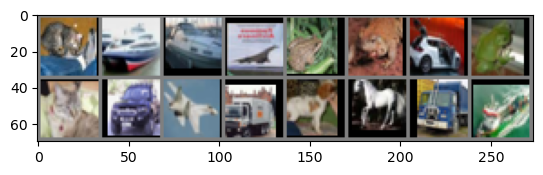

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

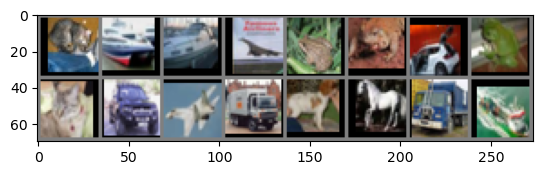

Predicted:  cat   car   ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck plane


In [ ]:
#Loading previous results
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

#Prédictions
imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))